# Why you should care:

- Be a good scientist.
- Replicability.
- Journals and funders are not kidding now.

# The basic setup:

In classical/frequentist stats, **probabilities are about the long run**.

We assume:
- an infinite series of experiments
- each time
    - we observe data $X$ (capital letters are random variables)
    - we calculate some numbers (called *statistics*) based on these data $T(X)$ (also random)
    - we make a decision based on these numbers $D(T(X))$
- probability is about *what fraction of the time* these random variables take on specific values
- (you could be Bayesian, but we'll get to that)

## Example 1:

We are going to measure reaction times of two groups of individuals:
- data are the set of RTs for each subject
- statistics are means of RT sets for each subject, population
- decision is whether or not to reject the null hypothesis that groups are the same

## Example 2:

We are going to measure ERP responses multiple times in a single individual in multiple conditions:
- data are the timecourses of ERP on each trial
- statistics are, e.g., mean time course or mean of difference wave in a predefined epoch
- decision is whether to reject the null hypothesis that the ERPs are the same

## Example 3:

We are going to treat depressive patients with TMS:
- data are response metrics (self-reports, diaries, clinician ratings)
- statistics are means, variances, something else?
- decision is how much to dose next time

## Bottom line:

This is *very broad*.

**Probability** is about making statements about long-term behavior in this setup well-defined.

**Statistics** is about studying the properties of the quantities we calculate from data.

# How good is our procedure?

For this lecture, we'll specialize to *binary decisions*: yes or no, accept or reject the null. **There's a lot more you can do!**

## Basic signal detection

Let's assume our decision is $D = 0$ or $D = 1$. The ground truth $GT$ is also 0 or 1, but we can get it wrong.

A quick review:
- $TP$: $P(D=1\vert GT=1)$
- $FN$: $P(D=0\vert GT=1) = \alpha$   (Type I)
- $TN$: $P(D=0\vert GT=0)$
- $FP$: $P(D=1\vert GT=0)=\beta$    (Type II)

Note:
$$TP + FN = 1$$
$$TN + FP = 1$$

## Experimenter degrees of freedom

What determines our error rates?
- **You** get to determine what and how much data $X$ to collect.
- **You** get to pick $T(X)$.
- **You** get to pick the test $D(T(X))$.
- **You** get to pick the threshold. (There usually is one.)

## So how do we win?

Pick a test that minimizes errors!

**Sad fact**: True and false positive rates trade off as we vary decision threshold.

![https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png](https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png)

**But**: Not all tests are created equal! Some ROC curves lie up and to the left *at all points* relative to some other curves.

## An important result

Traditionally, we cap false positive rates ($\alpha$), which determines our decision threshold, and ask how we can minimize false negative rates ($\beta$). This is equivalent to maximizing $1 - \beta$, which we call *power*.

In some cases, one can prove that there are *uniformly most powerful* (UMP) tests. In fact, 

**Theorem:** Tests based on ratios of likelihoods (~ probability of the data under each hypothesis) minimize error rates better than any other test. 

**Theorem (Neyman-Pearson):** If we fix our max false positive rate, then any other kind of test that lowers false positives will increase false negatives (relative to the likelihood ratio test).

# Classical power analysis

Again, we as experimenters have a few knobs to play with:

- $N$: Number of measurments, amount of data
- $T$: Statistic to compute (usually related to the test)
- $\alpha$: Acceptable false positive rate
- $1 - \beta$: Power

For a few select distributions ($t$, $F$, $\chi^2$, etc.), it's possible to calculate the relationships between these numbers.

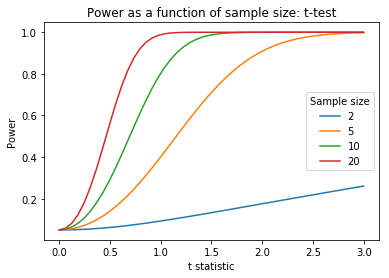

In [1]:
import numpy as np
import statsmodels.stats.power as pwr
import matplotlib.pyplot as plt
%matplotlib inline

tt = pwr.TTestPower()

eff_sizes = np.linspace(0, 3, 50)
sample_sizes = [2, 5, 10, 20]

for N in sample_sizes:
    plt.plot(eff_sizes, tt.solve_power(eff_sizes, nobs=N, alpha=0.05),
            label=N);
plt.title("Power as a function of sample size: t-test")
plt.xlabel("t statistic")
plt.ylabel("Power")
plt.legend(title="Sample size");

[credit](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/)

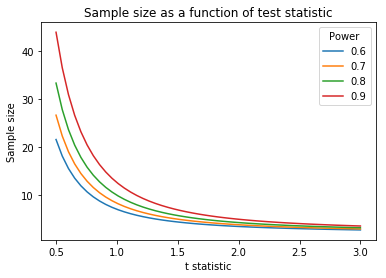

In [2]:
eff_sizes = np.linspace(0.5, 3, 50)
desired_power = [0.6, 0.7, 0.8, 0.9]
n_array = np.empty([len(desired_power), len(eff_sizes)])
for ii, pw in enumerate(desired_power):
    for jj, eff in enumerate(eff_sizes):
        n_array[ii, jj] = tt.solve_power(eff, power=pw, alpha=0.05)
        
plt.plot(eff_sizes, n_array.T)
plt.title("Sample size as a function of test statistic")
plt.xlabel("t statistic")
plt.ylabel("Sample size")
plt.legend(labels=desired_power, title="Power");

# Back in the real world...

You are probably not running a simple statistical test. Or if you are, you're not running just one.

The only thing to do in this case is **simulate**.

## A simple example

Let's assume we have a single neuron that responds to some stimulus by increasing 
its firing rate above baseline. That is, we'll observe this neuron for a whole
series of brief stimulus presentations and count up all the spikes.

**Dramatis Personae**:
- $T$: observation time (seconds)
- $\lambda_0$: baseline firing rate of cell (spikes/second).
- $s$: stimulus strength.
- $\beta$: firing rate effect (see below)
- $C$: spike counts in the observation window

We are going to fit these data with a [Generalized Linear Model](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLM).
The assumption of this model is that the counts are Poisson distributed:
$$C \sim \mathrm{Poisson}(\lambda T)$$
with 
$$\lambda = \lambda_0 e^{\beta s}$$
(The assumption of the GLM is that log firing rates are linear, which is why we do this.)

## 1. Make fake data

In [3]:
np.random.seed(12345)  # for reproducibility
T = 1.0
lam0 = 10
beta = 2
s = 1

In [4]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

ntrials = 50

C = np.concatenate([stats.poisson.rvs(lam0 * T, size=ntrials), 
                    stats.poisson.rvs(lam0 * T * np.exp(beta * s), size=ntrials)])

/Users/jmxp/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Text(0.5,0,'Spike Count')

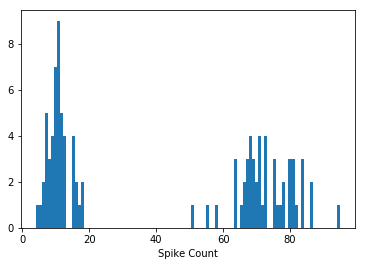

In [5]:
plt.hist(C, bins=100);
plt.xlabel("Spike Count")

## 2. Analyze fake data

In [6]:
import pandas as pd

df = pd.DataFrame({'count': C, 'stim': np.concatenate([np.zeros(ntrials), np.ones(ntrials)])})
df.head()

,count,stim
0,16,0.0
1,7,0.0
2,11,0.0
3,18,0.0
4,12,0.0


In [7]:
fit = smf.glm(formula="count ~ stim", data=df, family=sm.families.Poisson()).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -306.37
Date:                Mon, 10 Sep 2018   Deviance:                       97.221
Time:                        13:11:03   Pearson chi2:                     96.1
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3832      0.043     55.484      0.000       2.299       2.467
stim           1.9042      0.046     41.358      0.000       1.814       1.994
==============================================================================
"""

In [8]:
fit.pvalues, fit.pvalues['stim'] < 0.05

(Intercept    0.0
 stim         0.0
 dtype: float64, True)

## 3. Automate and repeat

In [9]:
def run_expt(baseline, effect, T, stim, Ntrials):
    # run a single synthetic experiment, return p-value for GLM
    
    baseline_rates = baseline * np.ones(Ntrials)
    stim_rates = baseline * np.exp(effect * stim) * np.ones(Ntrials)
    
    # random counts
    baseline_counts = stats.poisson.rvs(baseline_rates * T)
    stim_counts = stats.poisson.rvs(stim_rates * T)
    
    # make data frame
    df = pd.DataFrame({'count': np.concatenate([baseline_counts, stim_counts]), 
                       'stim': np.concatenate([np.zeros(ntrials), np.ones(ntrials)])})

    # fit model
    fit = smf.glm(formula="count ~ stim", data=df, family=sm.families.Poisson()).fit()

    # test
    return fit.pvalues['stim']

In [10]:
def calc_power(alpha, Nexpt, exptfun, *args):
    # calculate power for an experiment defined by false positive rate alpha and repeated Nexpt times
    # exptfun returns an object with a pvalue
    # args are passed on to exptfun
    
    pvals = np.array([exptfun(*args) for _ in range(Nexpt)])
    
    return np.mean(pvals < alpha)

In [11]:
alpha = 0.05
Nexpt = 100
baseline = 10.  # firing rate in Hz
T = 1.0
effect = .2  # fractional change from baseline
stim = 1
Ntrials = 50  # number of trials for each stimulus

calc_power(alpha, Nexpt, run_expt, baseline, effect, T, stim, Ntrials)

0.88

In [12]:
effect_sizes = np.linspace(0.05, 0.4, 50)

powers = np.array([calc_power(alpha, Nexpt, run_expt, baseline, eff, T, stim, Ntrials) for eff in effect_sizes])

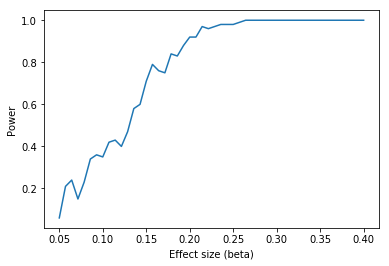

In [13]:
plt.plot(effect_sizes, powers);
plt.xlabel('Effect size (beta)')
plt.ylabel('Power');

Now, this is only a simple example. It ignores a lot of important sources of variance and
so overestimates power. A somewhat more realistic example can be found [here](https://gist.github.com/jmxpearson/077407a40aaf967eb12db41b6c851f1d).

# Final thoughts

There is a vast, vast literature on designing experiments, but much of it is either
restricted to simple cases (from the days when experiments were simpler and 
computation expensive) or geared toward clinical trials (where millions of dollars
are at stake).

Two options worth thinking about:
- To do permutation testing, you have to simulate. So power analysis is not a big deal.
- If you are a Bayesian, [you don't need it in the same way](https://link.springer.com/article/10.3758/s13423-014-0595-4).

This is a place where there's a lot to be done in the next few years, as
statistics and experimental design attempt to catch up to neuroscience praxis.